
#use multinomial naive bayes algorithm after the other models

# Imports

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import spacy
import re
import acquire, prepare

from importlib import reload
from itertools import product
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

## Term Frequency
`Raw Count`: This is simply the count of the number of occurances of each word.  
`Frequency`: The number of times each word appears divided by the total number of words.  
`Augmented Frequency`: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

In [2]:
document = 'Mary had a little lam, a little lam, a little lam.'

document = document.lower()\
                    .replace(',', ' ')\
                    .replace('.', '')
words = pd.Series(document.split())

#from series extra value counts (raw count of term frequency[TF]).
# can then us to calc other measures
(pd.DataFrame({'raw_count': words.value_counts()})
.assign(frequency=lambda df: df.raw_count / df.raw_count.sum()) # create frequency column
.assign(augmented_frequency=lambda df: df.frequency / df.frequency.max())) # create augmented frequency column

,raw_count,frequency,augmented_frequency
a,3,0.272727,1.000000
little,3,0.272727,1.000000
lam,3,0.272727,1.000000
mary,1,0.090909,0.333333
had,1,0.090909,0.333333


## Inverse Document Frequency
* must have multiple documents 
* provides ide of how much informationa word provides
* based on commonality of word appearance across docs
* higher freq == lower IDF

Text(0.5, 1.0, 'IDF for a given word')

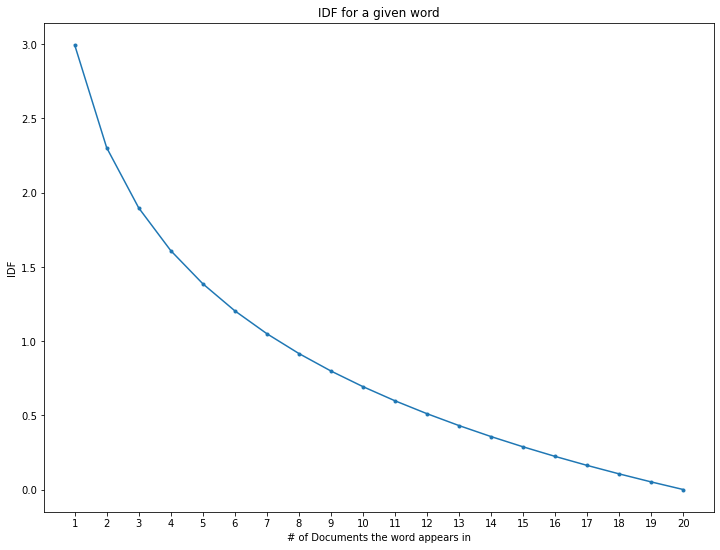

In [3]:
#example of relationship between frequency and IDF score
n_documents = 20

x = np.arange(1, n_documents +1)
y = np.log(n_documents / x)

plt.figure(figsize=(12,9))
plt.plot(x,y, marker='.')

plt.xticks(x)
plt.xlabel('# of Documents the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')

### Calculating IDF for multipel words

In [4]:
#generate 3 example documents
documents = {
    'news': 'Codeup announced last thursday that they just launched a new data science program. It is 18 weeks long.',
    'description': 'Codeup\'s data science program teaches hands on skills using Python and pandas.',
    'conreadme_txt': 'Codeup\'s data science program was created in response to a percieved lack of data science talent, and growing demand.'
}

pprint(documents)

pprint('\nCleaning and lemmatizing...\n')

documents = {topic: prepare.lemmatize(prepare.basic_clean(documents[topic])) for topic in documents}

pprint(documents)

{'context': "Codeup's data science program was created in response to a "
            'percieved lack of data science talent, and growing demand.',
 'description': "Codeup's data science program teaches hands on skills using "
                'Python and pandas.',
 'news': 'Codeup announced last thursday that they just launched a new data '
         'science program. It is 18 weeks long.'}
'\nCleaning and lemmatizing...\n'
{'context': "codeup's data science program wa created in response to a "
            'percieved lack of data science talent and growing demand',
 'description': "codeup's data science program teach hand on skill using "
                'python and panda',
 'news': 'codeup announced last thursday that they just launched a new data '
         'science program it is 18 week long'}


### Calculate IDF for each word

In [5]:
#create func
def idf(word):
    """ 
    Purpose:
        
    ---
    Parameters:
        
    ---
    Returns:
    
    """
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / n_occurences  

In [6]:
# get list of unique qwords
unique_words = pd.Series(' '.join(documents.values()).split()).unique()

#put unique words into a data frame
(pd.DataFrame(dict(word=unique_words))
.assign(idf=lambda df: df.word.apply(idf))
.set_index('word')
.sort_values(by='idf', ascending=False)
.head(5))

,idf
word,
teach,3.0
created,3.0
hand,3.0
skill,3.0
using,3.0


## TF-IDF

In [7]:
tfs = []

#calculate tf-idf value for every word across every document

#iterate over all documents
for doc, readme_txt in documents.items():
    #make dataframe that contains the tf for every word in every document
    df = (pd.Series(readme_txt.split())
            .value_counts()
            .reset_index()
            .set_axis(['word', 'raw_count'], axis=1, inplace=False)
            .assign(tf=lambda df: df.raw_count / df.shape[0])
            .drop(columns='raw_count')
            .assign(doc=doc))
    
    # append dataframe to list
    tfs.append(df)

#concatenate all tf values together
(pd.concat(tfs)
#calculate the idf value for each word
    .assign(idf=lambda df: df.word.apply(idf))
    .assign(tf_idf=lambda df: df.idf * df.tf)
    .drop(columns=['tf', 'idf'])
    .sort_values(by='tf_idf', ascending = False))

,word,doc,tf_idf
5,hand,description,0.250000
4,teach,description,0.250000
11,panda,description,0.250000
9,python,description,0.250000
8,using,description,0.250000
7,skill,description,0.250000
14,wa,context,0.176471
13,created,context,0.176471
11,response,context,0.176471
9,to,context,0.176471


In [8]:
#we'll then concatenate all the tf values together
(pd.concat(tfs) 
#calcualte the idf calue for each word
 .assign(idf=lambda df: df.word.apply(idf))
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False)
 .pipe(lambda df: pd.crosstab(df.doc, df.word, values=df.tf_idf, aggfunc=lambda x:x))
 .fillna(0))

word,18,a,and,announced,codeup,codeup's,created,data,demand,growing,...,skill,talent,teach,that,they,thursday,to,using,wa,week
doc,,,,,,,,,,,,,,,,,,,,,
context,0.000000,0.058824,0.088235,0.000000,0.000000,0.088235,0.176471,0.117647,0.176471,0.176471,...,0.00,0.176471,0.00,0.000000,0.000000,0.000000,0.176471,0.00,0.176471,0.000000
description,0.000000,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000,0.083333,0.000000,0.000000,...,0.25,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000
news,0.166667,0.055556,0.000000,0.166667,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,...,0.00,0.000000,0.00,0.166667,0.166667,0.166667,0.000000,0.00,0.000000,0.166667


## TF-IDF with scikit-learn

In [9]:
from sklearn.feature_extraction.readme_txt import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(documents.values())
tfidfs

<3x36 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>

In [10]:
pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,18,and,announced,codeup,created,data,demand,growing,hand,in,...,skill,talent,teach,that,they,thursday,to,using,wa,week
0,0.263566,0.000000,0.263566,0.155666,0.000000,0.155666,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.263566,0.263566,0.263566,0.000000,0.000000,0.000000,0.263566
1,0.000000,0.253880,0.000000,0.197160,0.000000,0.197160,0.000000,0.000000,0.333821,0.000000,...,0.333821,0.000000,0.333821,0.000000,0.000000,0.000000,0.000000,0.333821,0.000000,0.000000
2,0.000000,0.195932,0.000000,0.152159,0.257627,0.304317,0.257627,0.257627,0.000000,0.257627,...,0.000000,0.257627,0.000000,0.000000,0.000000,0.000000,0.257627,0.000000,0.257627,0.000000


# Modeling

In [13]:
df = ###
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Fit Vectorizer

In [14]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_txt)
y = df.label

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [ ]:
train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle.split_scale(df, 'y')

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28450 entries, 26127 to 19091
Columns: 171 entries, household_num to occupation_11.0
dtypes: float64(7), int64(9), uint8(155)
memory usage: 7.9 MB


# Setup
Explore various models and feature combinations.
Choose **three** models to validate. Choose **one** to test. 
Artifact: `model.py`

### Modeling Preparation
- 

### Baseline Prediction and Accuracy

In [ ]:
# formulate baseline prediction
train.language.value_counts(normalize=True)

1    0.962882
0    0.037118
Name: employed, dtype: float64

In [ ]:
def split_X_y(df):
    # split data into Big X, small y sets 
    X_train = train.drop(columns=['language'])
    y_train = train.language

    X_validate = validate.drop(columns=['language'])
    y_validate = validate.language

    X_test = test.drop(columns=['language'])
    y_test = test.language

    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [ ]:
def compute_metrics(model, X_df, y_df):
    """
    purpose: function executes performs computations to produce evaulation metrics for a given model

    inputs: 
        model: a model that has been previous fit to spec
        X_df: a dataframe featuring the X subset of data for evaluation
        y_df: a dataframe featuring the model target variable

    Returns: a rounded pandas Series that can be adding to an evaulation metric comparison chart
    """
    # Make Predictions
    y_pred = model.predict(X_df)

    # Estimate Probability 
    y_pred_proba = model.predict_proba(X_df)

    #create confusion matrix
    confusion = confusion_matrix(y_df, y_pred)

    #assign results of confusion matrix to variables
    true_negative = confusion[0,0]
    false_positive = confusion[0,1]
    false_negative = confusion[1,0]
    true_positive = confusion[1,1]

    #accuracy
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

    #true positive rate / recall
    recall = true_positive / (true_positive +false_negative)

    #false positive rate
    false_positive_rate = false_positive / (true_negative + false_positive)

    #true negative rate
    true_negative_rate = true_negative / (true_negative + false_positive)

    #false negative rate
    false_negative_rate = false_negative / (false_negative + true_positive)

    #precision
    precision = true_positive / (true_positive + false_positive)

    #f1-score
    f1_score = 2 * (precision * recall) / (precision + recall)

    #support
    support_positive = true_positive + false_negative
    support_negative = false_positive + true_negative

    metrics = pd.Series([accuracy, true_positive, false_positive, true_negative, false_negative,\
                        recall, false_positive_rate, true_negative_rate, false_negative_rate, \
                        precision, f1_score, support_positive, support_negative])
                        
    return metrics.round(4)

In [ ]:
def create_comp_chart():
    """
    purpose: to create a dataframe with an index reflecting compuation metrics for future models

    returns: a pandas dataframe with appropriately set index
    """
    statistics = ['Accuracy/Score',
    'True Positives' , 'False Positives', 'True Negatives', 'False Negatives', \
    'TPR/Recall', 'False Positive Rate', 'True Negative Rate', 'False Negative Rate', \
    'Precision', 'F1-Score', 'Support Positive', 'Support Negative']


    return pd.DataFrame({}, index=statistics)

In [ ]:
# split data into Big X, small y sets 
X_train = train.drop(columns=['language'])
y_train = train.language

X_validate = validate.drop(columns=['language'])
y_validate = validate.language

X_test = test.drop(columns=['language'])
y_test = test.language


In [ ]:
# formulate baseline accuracy
baseline_accuracy = (y_train == 1).mean()

print(f'Baseline Accuracy for \"language\" prediction: {(baseline_accuracy * 100): .3}%')

Baseline Accuracy for "unemployed" prediction on Telco dataset:  96.3%


In [ ]:
def create_description_chart(y):

    # formulate baseline accuracy
    baseline_accuracy = (y == 1).mean()

    descriptions = pd.DataFrame({'Model': 'Baseline', \
                                'Accuracy(Score)': baseline_accuracy,
                                'Type': 'Basic Baseline',
                                'Features Used': 'Baseline Prediction',
                                'Parameters': 'n/a'
                                }, index=[0])
    
    return descriptions

In [ ]:
model_descriptions = pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    'Parameters': 'n/a'
    }, index=[0])

In [ ]:
pd.concat([model_descriptions, pd.DataFrame({'Model': 'Baseline', \
    'Accuracy(Score)': baseline_accuracy,
    'Type': 'Basic Baseline',
    'Features Used': 'Baseline Prediction',
    'Parameters': 'n/a'
    }, index=[0]) ], ignore_index=True)

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.962882,Basic Baseline,Baseline Prediction,n/a
1,Baseline,0.962882,Basic Baseline,Baseline Prediction,n/a


In [ ]:
comparison_chart = model.create_comp_chart()

# Models

## Decision Tree

In [ ]:
feat_set = ['marital_status', 'occupation', 'race', 'education', 'citizenship']

In [ ]:
subsets = [train, X_train, y_train]

In [ ]:
def model_dtc(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product(np.arange(20,25,2)))

    for idx, item in enumerate(selectors):
        model_id = 'DTC_'+f'{idx}'
        dtc = DecisionTreeClassifier(max_depth=item[0],\
                                            random_state=514)
        
        dtc.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(dtc, X_train[features], y_train).values

        score = dtc.score(X_train[features], y_train).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Decision Tree Classifier',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}'},
                                    index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [ ]:
model_descriptions, comparison_chart =  model_dtc(feat_set, model_descriptions, comparison_chart, subsets)

In [ ]:
model_descriptions

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.962882,Basic Baseline,Baseline Prediction,n/a
1,DTC_0,0.968200,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 20
2,DTC_1,0.968200,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 22
3,DTC_2,0.968200,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 24
4,RF_5,0.968200,Random Forest,"['marital_status', 'occupation', 'race', 'educ...","Depth: 25, Leaves: 1"
5,Knn_1,0.936450,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 1
6,Knn_2,0.927140,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 2
7,Knn_3,0.963660,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 3
8,Knn_4,0.963130,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 4
9,Knn_5,0.966680,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 5


## Random Forest

In [ ]:
def model_rf(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    selectors = list(product([20,25], [3,2,1]))

    for idx, item in enumerate(selectors):
        model_id = 'RF_'+f'{idx}'
        rf = RandomForestClassifier(max_depth=item[0],\
                                            min_samples_leaf=item[1],
                                            random_state=514)
        
        rf.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(rf, X_train[features], y_train).values

        score = rf.score(X_train[features], y_train).round(4)

        description = pd.DataFrame({'Model': model_id,
                                    'Accuracy(Score)': score,
                                    'Type': 'Random Forest',
                                    'Features Used': f'{feat_set}',
                                    'Parameters': f'Depth: {item[0]}, Leaves: {item[1]}'},
                                    index=[0])
       
    model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)

    return model_descriptions, comparison_chart

In [ ]:
model_descriptions, comparison_chart = model_rf(feat_set, model_descriptions, comparison_chart)

### Takeaways - Random Forest
* 

## KNN (K-Nearest Neighbors)

In [ ]:
## K-Nearest Neighbors
def model_knn(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    k_range = range(1, 15)
    scores = []
    
    for k in k_range:
        
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train[features], y_train)
        scores.append(knn.score(X_train[features], y_train))

        model_id = 'Knn_'+f'{k}'

        comparison_chart[model_id] = model.compute_metrics(knn, X_train[features], y_train).values

        score = knn.score(X_train[features], y_train).round(5)

        description = pd.DataFrame({'Model': model_id,
            'Accuracy(Score)': score,
            'Type': 'Knn',
            'Features Used': f'{feat_set}',
            'Parameters': f'K-Neighbors: {k}'},
            index=[0])

        model_descriptions = pd.concat([model_descriptions, description], ignore_index=True)
   
    plt.figure()
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.scatter(k_range, scores)
    plt.xticks([0,5,10,15,20])
    plt.show()
    np.mean(scores)

    
    return model_descriptions, comparison_chart

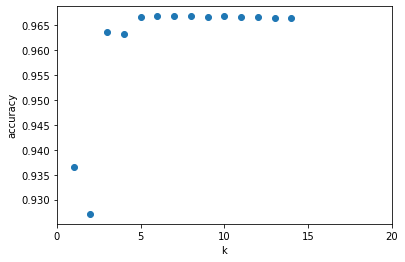

In [ ]:
model_descriptions, comparison_chart = model_knn(feat_set, model_descriptions, comparison_chart)

In [ ]:
model_descriptions.sort_values(by='Accuracy(Score)', ascending=False).head()

,Model,Accuracy(Score),Type,Features Used,Parameters
0,DTC_1,0.96820,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 22
0,DTC_2,0.96820,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 24
0,RF_5,0.96820,Random Forest,"['marital_status', 'occupation', 'race', 'educ...","Depth: 25, Leaves: 1"
0,DTC_0,0.96820,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 20
0,Knn_7,0.96675,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 7


## Logistic Regression

In [ ]:
def model_lr(feat_set,\
        model_descriptions,
        comparison_chart,
        subsets, ):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]

    features = []
    for feature in feat_set:
        features += [col for col in train.columns if feature in col]

    cees = [.1,.5,1]
    solver = ['newton-cg', 'lbfgs']
    weights = [None, 'balanced']

    selectors = list(product(cees, solver, weights))

    for idx, item in enumerate(selectors):
        model_id = 'LR_'+f'{idx}'
        lr = LogisticRegression(C=item[0],\
                                solver=item[1],
                                class_weight=item[2],
                                max_iter=400,
                                random_state=514)
        
        lr.fit(X_train[features], y_train)

        comparison_chart[model_id] = model.compute_metrics(lr, X_train[features], y_train).values

        score = lr.score(X_train[features], y_train).round(4)

        model_descriptions.loc[idx+1] = {'Model': model_id,
            'Accuracy(Score)': score,
            'Type': 'Logistic Regression',
            'Features Used': f'{feat_set}',
            'Parameters': f'C: {item[0]}, Solver: {item[1]}, Class Weight: {item[2]}'
        }

    return model_descriptions, comparison_chart

In [ ]:
model_descriptions, comparison_chart = model_lr(feat_set, model_descriptions, comparison_chart)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Model Description and Comparison Charts


In [ ]:
model_descriptions.groupby('Type')['Accuracy(Score)'].mean()

Type
Basic Baseline              0.962882
Decision Tree Classifier    0.968200
Knn                         0.961197
Logistic Regression         0.806528
Random Forest               0.968200
Name: Accuracy(Score), dtype: float64

In [ ]:
#model descriptions
model_descriptions.sort_values('Accuracy(Score)', ascending=False).head(20)

,Model,Accuracy(Score),Type,Features Used,Parameters
0,DTC_0,0.96820,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 20
0,DTC_1,0.96820,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 22
0,DTC_2,0.96820,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 24
0,RF_5,0.96820,Random Forest,"['marital_status', 'occupation', 'race', 'educ...","Depth: 25, Leaves: 1"
9,LR_8,0.96770,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 0.5, Solver: lbfgs, Class Weight: None"
17,LR_16,0.96770,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 1, Solver: sag, Class Weight: None"
15,LR_14,0.96770,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 1, Solver: lbfgs, Class Weight: None"
5,LR_4,0.96770,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 0.1, Solver: sag, Class Weight: None"
11,LR_10,0.96770,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 0.5, Solver: sag, Class Weight: None"
3,LR_2,0.96770,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 0.1, Solver: lbfgs, Class Weight: None"


In [ ]:
comparison_chart.T.sort_values(by='True Negatives', ascending=False).head(25).sort_values(by=['Accuracy/Score'])

,Accuracy/Score,True Positives,False Positives,True Negatives,False Negatives,TPR/Recall,False Positive Rate,True Negative Rate,False Negative Rate,Precision,F1-Score,Support Positive,Support Negative
LR_17,0.4936,13491.0,504.0,552.0,13903.0,0.4925,0.4773,0.5227,0.5075,0.9640,0.6519,27394.0,1056.0
LR_5,0.6577,18074.0,419.0,637.0,9320.0,0.6598,0.3968,0.6032,0.3402,0.9773,0.7878,27394.0,1056.0
LR_3,0.6577,18074.0,419.0,637.0,9320.0,0.6598,0.3968,0.6032,0.3402,0.9773,0.7878,27394.0,1056.0
LR_1,0.6577,18074.0,419.0,637.0,9320.0,0.6598,0.3968,0.6032,0.3402,0.9773,0.7878,27394.0,1056.0
LR_15,0.6581,18086.0,418.0,638.0,9308.0,0.6602,0.3958,0.6042,0.3398,0.9774,0.7881,27394.0,1056.0
LR_13,0.6581,18086.0,418.0,638.0,9308.0,0.6602,0.3958,0.6042,0.3398,0.9774,0.7881,27394.0,1056.0
LR_9,0.6582,18089.0,418.0,638.0,9305.0,0.6603,0.3958,0.6042,0.3397,0.9774,0.7882,27394.0,1056.0
LR_7,0.6583,18091.0,418.0,638.0,9303.0,0.6604,0.3958,0.6042,0.3396,0.9774,0.7882,27394.0,1056.0
LR_11,0.7088,19651.0,541.0,515.0,7743.0,0.7173,0.5123,0.4877,0.2827,0.9732,0.8259,27394.0,1056.0
Knn_2,0.9271,26117.0,796.0,260.0,1277.0,0.9534,0.7538,0.2462,0.0466,0.9704,0.9618,27394.0,1056.0


In [ ]:
comparison_chart.T.sort_values(by='Accuracy/Score', ascending=False).head(25).sort_values(by=['False Positives'])

,Accuracy/Score,True Positives,False Positives,True Negatives,False Negatives,TPR/Recall,False Positive Rate,True Negative Rate,False Negative Rate,Precision,F1-Score,Support Positive,Support Negative
DTC_0,0.9682,27379.0,889.0,167.0,15.0,0.9995,0.8419,0.1581,0.0005,0.9686,0.9838,27394.0,1056.0
DTC_2,0.9682,27379.0,889.0,167.0,15.0,0.9995,0.8419,0.1581,0.0005,0.9686,0.9838,27394.0,1056.0
DTC_1,0.9682,27379.0,889.0,167.0,15.0,0.9995,0.8419,0.1581,0.0005,0.9686,0.9838,27394.0,1056.0
RF_2,0.9682,27390.0,900.0,156.0,4.0,0.9999,0.8523,0.1477,0.0001,0.9682,0.9838,27394.0,1056.0
RF_5,0.9682,27390.0,900.0,156.0,4.0,0.9999,0.8523,0.1477,0.0001,0.9682,0.9838,27394.0,1056.0
LR_2,0.9677,27394.0,918.0,138.0,0.0,1.0000,0.8693,0.1307,0.0000,0.9676,0.9835,27394.0,1056.0
RF_0,0.9677,27394.0,918.0,138.0,0.0,1.0000,0.8693,0.1307,0.0000,0.9676,0.9835,27394.0,1056.0
RF_1,0.9677,27394.0,918.0,138.0,0.0,1.0000,0.8693,0.1307,0.0000,0.9676,0.9835,27394.0,1056.0
RF_3,0.9677,27394.0,918.0,138.0,0.0,1.0000,0.8693,0.1307,0.0000,0.9676,0.9835,27394.0,1056.0
RF_4,0.9677,27394.0,918.0,138.0,0.0,1.0000,0.8693,0.1307,0.0000,0.9676,0.9835,27394.0,1056.0


## Model Creation Takeaways
- 

## Model Validation Takeaways
- Goal:
    - 

In [ ]:
top_20 = model_descriptions.sort_values('Accuracy(Score)', ascending=False).head(20)

In [ ]:
def get_selectors(parameters):
    removal_list = ['Depth: ','K-Neighbors: ','Leaves: ','C: ',' Solver: ', ' Class Weight: ']

    for word in removal_list:
        parameters = parameters.replace(word, "")

    return parameters.split(',')

In [ ]:
def score_on_validation(descriptions, subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]
    X_validate= subsets[3]
    y_validate = subsets[4]

    
    validate_metrics = create_comp_chart()
    val_descriptions = create_description_chart(y_validate)
    
    #feat_set = descriptions.iloc[1]['Features Used'].strip('\[]\'').split('\', \'')
    print(descriptions.index)
    for idx in descriptions.index:

        model_id = descriptions.loc[idx]['Model']
        feat_set = descriptions.loc[idx]['Features Used'].strip('\[]\'').split('\', \'')
        selectors = get_selectors(descriptions.loc[idx]['Parameters'])

        features = []

        for feature in feat_set:
            features += [col for col in train.columns if feature in col]

        if model_id.startswith('DTC'):
            val_model = DecisionTreeClassifier(max_depth=int(selectors[0]),\
                                                random_state=514)
        elif model_id.startswith('RF'):
            val_model = RandomForestClassifier(max_depth=int(selectors[0]),\
                                            min_samples_leaf=int(selectors[1]),
                                            random_state=514)
        elif model_id.startswith('Knn'):
            val_model = KNeighborsClassifier(n_neighbors = int(selectors[0]))
        elif model_id.startswith('LR'):
            val_model = LogisticRegression(C=float(selectors[0]),\
                                            solver=selectors[1],
                                            class_weight=selectors[2],
                                            max_iter=200,
                                            random_state=514)  
                                    
        val_model.fit(X_train[features], y_train)

        validate_metrics[model_id] = model.compute_metrics(val_model, X_validate[features], y_validate).values

        score = val_model.score(X_validate[features], y_validate).round(4)

        val_descriptions.loc[idx+1] = {'Model': model_id,
            'Accuracy(Score)': score,
            'Type': descriptions.loc[idx]['Type'],
            'Features Used': f'{feat_set}',
            'Parameters': descriptions.loc[idx]['Parameters']
        }
        
    val_descriptions.insert(loc=2, column='Sensitivity', value=0)

    for idx in val_descriptions.index:
        model_id = val_descriptions.loc[idx]['Model']
        if model_id != 'Baseline':
            val_descriptions.loc[idx, 'Sensitivity'] = validate_metrics.T.loc[model_id]['True Negative Rate']        


    return val_descriptions, validate_metrics

In [ ]:
val_descriptions, validate_metrics = score_on_validation(top_20)

In [ ]:
val_descriptions

,Model,Accuracy(Score),Type,Features Used,Parameters
0,Baseline,0.962933,Basic Baseline,Baseline Prediction,n/a
1,DTC_0,0.966500,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 20
10,LR_2,0.968300,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 0.1, Solver: lbfgs, Class Weight: None"
18,Knn_5,0.967100,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 5
16,Knn_10,0.967100,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 10
6,LR_16,0.968300,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 1, Solver: sag, Class Weight: None"
12,LR_0,0.968300,Logistic Regression,"['marital_status', 'occupation', 'race', 'educ...","C: 0.1, Solver: newton-cg, Class Weight: None"
4,RF_5,0.967900,Random Forest,"['marital_status', 'occupation', 'race', 'educ...","Depth: 25, Leaves: 1"
14,Knn_8,0.967200,Knn,"['marital_status', 'occupation', 'race', 'educ...",K-Neighbors: 8
2,DTC_1,0.966500,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 22


In [ ]:
validate_metrics.T.sort_values(by='True Negative Rate', ascending=False)

,Accuracy/Score,True Positives,False Positives,True Negatives,False Negatives,TPR/Recall,False Positive Rate,True Negative Rate,False Negative Rate,Precision,F1-Score,Support Positive,Support Negative
DTC_0,0.9665,11718.0,384.0,68.0,24.0,0.9980,0.8496,0.1504,0.0020,0.9683,0.9829,11742.0,452.0
DTC_1,0.9665,11718.0,384.0,68.0,24.0,0.9980,0.8496,0.1504,0.0020,0.9683,0.9829,11742.0,452.0
RF_5,0.9679,11737.0,386.0,66.0,5.0,0.9996,0.8540,0.1460,0.0004,0.9682,0.9836,11742.0,452.0
LR_2,0.9683,11742.0,387.0,65.0,0.0,1.0000,0.8562,0.1438,0.0000,0.9681,0.9838,11742.0,452.0
LR_16,0.9683,11742.0,387.0,65.0,0.0,1.0000,0.8562,0.1438,0.0000,0.9681,0.9838,11742.0,452.0
LR_0,0.9683,11742.0,387.0,65.0,0.0,1.0000,0.8562,0.1438,0.0000,0.9681,0.9838,11742.0,452.0
LR_4,0.9683,11742.0,387.0,65.0,0.0,1.0000,0.8562,0.1438,0.0000,0.9681,0.9838,11742.0,452.0
Knn_5,0.9671,11740.0,399.0,53.0,2.0,0.9998,0.8827,0.1173,0.0002,0.9671,0.9832,11742.0,452.0
Knn_8,0.9672,11742.0,400.0,52.0,0.0,1.0000,0.8850,0.1150,0.0000,0.9671,0.9833,11742.0,452.0
Knn_10,0.9671,11742.0,401.0,51.0,0.0,1.0000,0.8872,0.1128,0.0000,0.9670,0.9832,11742.0,452.0


### Takeaways
> Initial: All three chosen sets perform baseline. Need to re-adjust and re-attempt

In [ ]:
top_model = val_descriptions[val_descriptions.Model == 'DTC_0']

In [ ]:
top_model

,Model,Accuracy(Score),Type,Features Used,Parameters
1,DTC_0,0.9665,Decision Tree Classifier,"['marital_status', 'occupation', 'race', 'educ...",Depth: 20


In [ ]:
for idx in top_model.index:
    print(top_model.loc[idx]['Model'])

DTC_0


In [ ]:
def score_on_test(descriptions, subsets):
    
    train=subsets[0]
    X_train=subsets[1]
    y_train=subsets[2]
    X_test = subsets[5]
    y_test = subsets[6]

    test_metrics = create_comp_chart()
    test_descriptions = create_description_chart(y_test)
        
    for idx in descriptions.index:
        
        model_id = descriptions.loc[idx]['Model']
        feat_set = descriptions.loc[idx]['Features Used'].strip('\[]\'').split('\', \'')
        selectors = get_selectors(descriptions.loc[idx]['Parameters'])

        features = []

        for feature in feat_set:
            features += [col for col in train.columns if feature in col]

        if model_id.startswith('DTC'):
            test_model = DecisionTreeClassifier(max_depth=int(selectors[0]),\
                                                random_state=514)
        elif model_id.startswith('RF'):
            test_model = RandomForestClassifier(max_depth=int(selectors[0]),\
                                            min_samples_leaf=int(selectors[1]),
                                            random_state=514)
        elif model_id.startswith('Knn'):
            test_model = KNeighborsClassifier(n_neighbors = int(selectors[0]))
        elif model_id.startswith('LR'):
            test_model = LogisticRegression(C=float(selectors[0]),\
                                            solver=selectors[1],
                                            class_weight=selectors[2],
                                            max_iter=200,
                                            random_state=514)  
                                    
        test_model.fit(X_train[features], y_train)

        test_metrics[model_id] = compute_metrics(test_model, X_test[features], y_test).values

        score = test_model.score(X_test[features], y_test).round(4)

        test_descriptions.loc[idx+1] = {'Model': model_id,
            'Accuracy(Score)': score,
            'Type': descriptions.loc[idx]['Type'],
            'Features Used': f'{feat_set}',
            'Parameters': descriptions.loc[idx]['Parameters']
        }

    return test_descriptions, test_metrics


In [ ]:
test_descriptions, test_metrics = score_on_test(top_model)

In [ ]:
test_metrics

,DTC_0
Accuracy/Score,0.9663
True Positives,9771.0000
False Positives,328.0000
True Negatives,49.0000
False Negatives,14.0000
TPR/Recall,0.9986
False Positive Rate,0.8700
True Negative Rate,0.1300
False Negative Rate,0.0014
Precision,0.9675


In [ ]:
def create_comp_chart():
    """
    purpose: to create a dataframe with an index reflecting compuation metrics for future models

    returns: a pandas dataframe with appropriately set index
    """
    statistics = ['Accuracy/Score',
    'True Positives' , 'False Positives', 'True Negatives', 'False Negatives', \
    'TPR/Recall', 'False Positive Rate', 'True Negative Rate', 'False Negative Rate', \
    'Precision', 'F1-Score', 'Support Positive', 'Support Negative']


    return pd.DataFrame({}, index=statistics)

In [ ]:
def train_models(X, y, feature_groups, subsets):
    
   #take in features sets and run them through each of the different types
   #of models and their variations
   train_descriptions = create_description_chart(y)
   train_metrics = create_comp_chart()

   for features in feature_groups:
      
      train_descriptions, train_metrics = model_dtc(features, train_descriptions, train_metrics, subsets)
      train_descriptions, train_metrics = model_rf(features, train_descriptions, train_metrics, subsets)
      #train_descriptions, train_metrics = model_knn(features, train_descriptions, train_metrics, subsets)
      train_descriptions, train_metrics = model_lr(features, train_descriptions, train_metrics, subsets)

   train_descriptions.insert(loc=2, column='Sensitivity', value=0)

   for idx in train_descriptions.index:
      model_id = train_descriptions.iloc[idx]['Model']
      if model_id != 'Baseline':
         train_descriptions.loc[idx, 'Sensitivity'] = train_metrics.T.loc[model_id]['True Negative Rate']
         
   return train_descriptions, train_metrics

In [ ]:
def for_final_report(train, feature_bank):

    X_train, y_train, X_validate, y_validate, X_test, y_test = split_X_y(train)

    subsets=[train, X_train, y_train, X_validate, y_validate, X_test, y_test]

    train_descriptions, train_metrics = train_models(X_train, y_train, feature_bank, subsets)

    train_descriptions[train_descriptions.Sensitivity > .20].\
        sort_values('Accuracy(Score)', ascending=False).\
        head(20)

    top_4 = train_descriptions[train_descriptions.Sensitivity > .20].\
        sort_values('Accuracy(Score)', ascending=False).\
        head(4)

    val_descriptions, validate_metrics = score_on_validation(top_4, subsets)

    top_1 = val_descriptions[(val_descriptions.Sensitivity > .20) & (val_descriptions['Accuracy(Score)'] > .66)].\
        sort_values('Sensitivity', ascending=False).\
        head(1)

    test_descriptions, test_metrics = score_on_test(top_1, subsets)

    return test_metrics

In [ ]:
for_final_report(train, [feat_set])

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Int64Index([12, 8, 10, 14], dtype='int64')


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,LR_7
Accuracy/Score,0.6684
True Positives,6554.0000
False Positives,139.0000
True Negatives,238.0000
False Negatives,3231.0000
TPR/Recall,0.6698
False Positive Rate,0.3687
True Negative Rate,0.6313
False Negative Rate,0.3302
Precision,0.9792
